In [2]:
import os
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import re

import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

### Finance Data

In [45]:
CLEAN_PATH = '../data/data_clean/us_school_districts.csv'

df = pd.read_csv(CLEAN_PATH)

In [46]:
finances_2016 = df[(df.YRDATA == 2016)]
finances_2016 = finances_2016.reset_index(drop=True)
finances_2016.info()
finances_2016[finances_2016.STATE == 'Arizona']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14325 entries, 0 to 14324
Data columns (total 24 columns):
STATE        14325 non-null object
ENROLL       14325 non-null float64
NAME         14325 non-null object
YRDATA       14325 non-null int64
TOTALREV     14325 non-null int64
TFEDREV      14325 non-null int64
TSTREV       14325 non-null int64
TLOCREV      14325 non-null int64
LOCRTAX      14325 non-null float64
LOCRPROP     14325 non-null float64
LOCREVPAR    0 non-null float64
PCTTOTAL     14325 non-null float64
PCTFTOT      14325 non-null float64
PCTSTOT      14325 non-null float64
PCTLTOT      14325 non-null float64
TOTALEXP     14325 non-null int64
TCURSPND     14325 non-null float64
TSALWAGE     14325 non-null float64
TEMPBENE     14325 non-null float64
TCURINST     14325 non-null int64
TCURSSVC     14325 non-null int64
PPCSTOT      14325 non-null float64
PPITOTAL     14325 non-null float64
PPSTOTAL     14325 non-null float64
dtypes: float64(14), int64(8), object(2)
memory u

,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL
189,Arizona,992.0,FORT HUACHUCA ACCOMMODATION SCHOOL,2016,14019,7699,5720,600,0.0,0.0,NaN,100.0,54.9,40.8,4.3,9946,9631.0,5996.0,1976.0,4997,4286,9709.0,5037.0,4321.0
190,Arizona,120.0,COCONINO COUNTY REGIONAL ACCOMODATION DISTRICT,2016,2796,491,1771,534,0.0,0.0,NaN,100.0,17.6,63.3,19.1,2077,1864.0,1046.0,313.0,756,1100,15533.0,6300.0,9167.0
191,Arizona,80.0,GILA COUNTY REGIONAL SCHOOL DISTRICT,2016,674,225,304,145,0.0,0.0,NaN,100.0,33.4,45.1,21.5,342,342.0,182.0,50.0,191,151,4275.0,2388.0,1888.0
192,Arizona,0.0,GRAHAM COUNTY SPECIAL SERVICES,2016,1446,553,32,861,0.0,0.0,NaN,100.0,38.2,2.2,59.5,1436,1433.0,716.0,302.0,534,899,0.0,0.0,0.0
193,Arizona,581.0,MARICOPA COUNTY REGIONAL SCHOOL DISTRICT,2016,3584,485,2677,422,0.0,0.0,NaN,100.0,13.5,74.7,11.8,4022,3714.0,2213.0,736.0,1678,2036,6392.0,2888.0,3504.0
194,Arizona,12.0,RAINBOW ACCOMMODATION SCHOOL,2016,145,7,130,8,0.0,0.0,NaN,100.0,4.8,89.7,5.5,320,320.0,189.0,63.0,147,173,26667.0,12250.0,14417.0
195,Arizona,45.0,PIMA ACCOMMODATION DISTRICT,2016,852,335,461,56,0.0,0.0,NaN,100.0,39.3,54.1,6.6,946,946.0,650.0,148.0,471,475,21022.0,10467.0,10556.0
196,Arizona,193.0,MARY C OBRIEN ACCOMMODATION DISTRICT,2016,5075,312,1768,2995,0.0,0.0,NaN,100.0,6.1,34.8,59.0,4726,4709.0,2577.0,1277.0,2132,2387,24399.0,11047.0,12368.0
197,Arizona,63.0,YAVAPAI ACCOMMODATION SCHOOL DISTRICT,2016,1165,60,687,418,0.0,0.0,NaN,100.0,5.2,59.0,35.9,985,985.0,438.0,169.0,428,557,15635.0,6794.0,8841.0
198,Arizona,73.0,ALPINE SCHOOL DISTRICT 7,2016,1093,208,450,435,373.0,373.0,NaN,100.0,19.0,41.2,39.8,990,990.0,555.0,134.0,654,336,13562.0,8959.0,4603.0


### Map Data

In [47]:
# Used to map state codes to state names for map data
state_map = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

In [48]:
# Import and configure map data
map_2016 = gpd.read_file('../data/data_clean/unsd_map/unsd_compiled.shp')

# Rename state column to align with finance data - astype int
map_2016 = map_2016.rename(columns={'STATEFP': 'STATE'})
map_2016.STATE = map_2016.STATE.astype(int)

# Exclude US territories (Codes above 56)
map_2016 = map_2016[map_2016.STATE <= 56]

# Map state codes to names
map_2016.STATE = map_2016.STATE.map(state_map)

# Remove 'not defined' districts
# map_2016 = map_2016[map_2016.NAME != 'not defined']

In [49]:
map_2016.info()
map_2016[map_2016.STATE == 'Arizona']

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10891 entries, 0 to 10890
Data columns (total 15 columns):
STATE       10891 non-null object
UNSDLEA     10891 non-null object
GEOID       10891 non-null object
NAME        10891 non-null object
LSAD        10891 non-null object
LOGRADE     10891 non-null object
HIGRADE     10891 non-null object
MTFCC       10891 non-null object
SDTYP       113 non-null object
FUNCSTAT    10891 non-null object
ALAND       10891 non-null int64
AWATER      10891 non-null int64
INTPTLAT    10891 non-null object
INTPTLON    10891 non-null object
geometry    10891 non-null geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 1.3+ MB


,STATE,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
191,Arizona,00001,0400001,Cave Creek Unified District,00,PK,12,G5420,None,E,538365755,129445,+33.7682294,-111.8588413,"MULTIPOLYGON (((-111.66538 33.73524, -111.6653..."
192,Arizona,00003,0400003,Chino Valley Unified District,00,PK,12,G5420,None,E,1041555215,157636,+34.8594247,-112.4467294,"POLYGON ((-112.73498 35.06900, -112.73454 35.0..."
193,Arizona,00021,0400021,Colorado City Unified District,00,PK,12,G5420,None,E,2161291697,863717,+36.6872576,-113.1156932,"POLYGON ((-113.32097 36.99999, -113.31863 36.9..."
194,Arizona,00023,0400023,Pinon Unified District,00,PK,12,G5420,None,E,2436154233,470679,+36.1323302,-110.3498472,"POLYGON ((-110.75070 36.15008, -110.75070 36.1..."
195,Arizona,00026,0400026,Heber-Overgaard Unified District,00,PK,12,G5420,None,E,1494550170,6967158,+34.4652586,-110.5612021,"POLYGON ((-110.75069 34.63665, -110.72951 34.6..."
196,Arizona,00212,0400212,Benson Unified School District,00,PK,12,G5420,None,E,1515150433,844008,+32.1545717,-110.2323326,"POLYGON ((-110.45166 32.40433, -110.45163 32.4..."
197,Arizona,00295,0400295,Kingman Unified School District,00,PK,12,G5420,None,E,7819471207,233354530,+35.5697848,-114.1715227,"POLYGON ((-114.75451 36.08617, -114.75378 36.0..."
198,Arizona,00520,0400520,Ajo Unified District,00,PK,12,G5420,None,E,344977148,0,+32.4183508,-112.8214191,"POLYGON ((-112.91656 32.38188, -112.91631 32.3..."
199,Arizona,00680,0400680,Amphitheater Unified District,00,PK,12,G5420,None,E,282471785,535621,+32.4129772,-110.9635991,"POLYGON ((-111.02998 32.39269, -111.02998 32.3..."
200,Arizona,00790,0400790,Apache Junction Unified District,00,PK,12,G5420,None,E,562136573,76198,+33.3846492,-111.4220685,"POLYGON ((-111.58430 33.37880, -111.58088 33.3..."


### Data Cleaning - 'NAME'

In [50]:
# Create maps to replace abbreviations and drop words
def create_maps(abbreviation_map, drop_map):
    abbreviation_map = {rf'\b{i}\b': word for i, word in my_map.items()}
    drop_map = {rf'\b{i}\b': word for i, word in drop_map.items()}
    
    return(abbreviation_map, drop_map)

my_map = {'plt': 'plantation',
         'ex': 'exempted',
#          'vlg': 'village',
         'n': 'north',
         'mt': 'mount',
         'mtn': 'mountain',
         'mts': 'mountain',
         'spgs': 'springs',
         'val': 'valley',
         'pk': 'park',
         'cons': 'consolidated',
         'coop': 'cooperative',
         'spec': 'special',
         'tech': 'technical',
         'ctr': 'center',
         'reorg': 'reorganized',
         'community': 'county',
         'cnty': 'county',
         'cmnty': 'county',
         'cmty': 'county',
         'comm': 'county',
         'com': 'county',
         'csd': 'county',
         'c': 'county',
         'co': 'county',
         'inc': 'corporation',
         'ind': 'independent',
         'indep': 'independent',
         'un': 'unified',
         'uni': 'unified',
         'unif': 'unified',
         'uf': 'union free',
         'hts': 'heights',
         'supv': 'supervisory',
         'ft': 'fort',
         'twp': 'township',
         'ctl': 'central',
         'elem': 'elementary'}

my_drop_map = {'schs': '',
            'sch': '',
            'sd': '',
            'dist': '',
            'disrict': '',
            'dt': '',
            'dis': '',
            'dst': '',
            'd': '',
            'isd': '',
            'board': '',
#             'independent': '',
            'no': '',
#             'county': '',
            'pub': '',
            'public': '',
            'school': '',
            'schools': '',
            'district': '',
            'system': '',
            'borough': '',
            'boro': '',
            'parish': '',
            'area': '',
            'island': '',
            'islands': '',
            'department': '',
            'municipal': '',
            'consolidated': '',
            'cooperative': '',
            'cooperatn': '',
            'city': '',
            'cty': '',
            'cy': '',
            'town': '',
            'twn': '',
            't': '',
            'merged': '',
            'cusd': '',
            'usd': '',
            'unit': '',
            'reg': '',
            'rj': '',
            'joint': '',
            'jt': '',
            'j': '',
            'voc': '',
            'village': '',
            'vil': '',
            'vlg': '',
            'vill': ''}

In [51]:
# Regex replacement dictionaries to clean district names
abbreviation_map, drop_map = create_maps(my_map, my_drop_map)

In [52]:
def clean_NAME(df):
    df.NAME = df.NAME.str.lower()
    
    # Replace abbreviations and drop non-essential words
    df.NAME = df.NAME.replace(abbreviation_map, regex=True)
    df.NAME = df.NAME.replace(drop_map, regex=True)
    
    # Drop 'r-' and 'r' and 're-' and 're ' from district codes [ need rX, reX next]
    df.NAME = df.NAME.str.replace(rf" r-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" r ", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re ", ' ', regex=True)
    
    # Some district codes are labeled reX or rX - remove re/r and following district code
    # This will affect 36 districts in Missouri and 2 in Colorado - negligable
    df.NAME = df.NAME.str.replace(rf"\bre\d+.\b", '', regex=True)
    df.NAME = df.NAME.str.replace(rf"\br\d+.\b", '', regex=True)
    df.NAME = df.NAME.str.replace(rf"\bre\d+\b", '', regex=True)
    df.NAME = df.NAME.str.replace(rf"\br\d+\b", '', regex=True)

    
    # Some districts spaced out 'de' (de pak vs. depak) - remove the spaces
    df.NAME = df.NAME.str.replace(rf"\bde \b", 'de', regex=True)
    
    df.NAME = df.NAME.str.replace(rf"\bmc \b", 'mc', regex=True)
    
    # Drop extra district codes found in '()'
    df.NAME = df.NAME.str.replace("\([^()]*\)", '', regex=True)
    
    # Drop '#' and '.' and '-' and '/' from districts
    df.NAME = df.NAME.str.replace('#', '', regex=False)
    df.NAME = df.NAME.str.replace('.', '', regex=False)
    df.NAME = df.NAME.str.replace('-', ' ', regex=False)
    df.NAME = df.NAME.str.replace('/', ' ', regex=False)
    df.NAME = df.NAME.str.replace("'", '', regex=False)
    
    # Distrcits inconsistantly use a 'j' in their district code tails - remove them
    df.NAME = df.NAME.str.replace('j$', '', regex=True)
    
    # Hawaii edge case
    df['NAME'][df.STATE == 'Hawaii'] = 'hawaii'
    
    df = df.sort_values(['STATE', 'NAME'])
    return df

In [53]:
def clean_NAME_whitespace(df):
    df.NAME = df.NAME.str.rstrip()
    df.NAME = df.NAME.str.lstrip()
    df.NAME = df.NAME.replace("\s+", ' ', regex=True)
    
    return(df)

In [58]:
clean_f = clean_NAME(finances_2016)
clean_m = clean_NAME(map_2016)

#========================================================
# Unique state by state naming conventions clean up
#========================================================

# These states have disctrict codes in finance data but none in map data
drop_codes = ['Arizona', 
             'Arkansas',
             'Georgia',
             'Michigan',
             'Minnesota',
             #'Missouri', 
             'Nebraska',
             'New Hampshire',
             'Oklahoma', 
             'Texas',
             'Washington', 
             'Wisconsin']

drop_county = ['Colorado',
              'Idaho',
              'Illinois',
              'Indiana',
              'Kansas',
              'Nebraska',
              'South Carolina',
              'Texas',
              'Utah',
              'West Virginia',
              'Wisconsin']

drop_independent = ['Georgia',
                   'Idaho',
                   'Minnesota',
                   'Texas']
drop_regional = ['Massachusetts',
                'New Hampshire']

drop_unified = ['Arizona',
               'Kansas',
               'Wisconsin']

# Map data does not include district codes for drop_codes states. Remove numbers from the above states
# There are 7 instances of a district code in the above states' map data - remove for consistancy
clean_f.loc[clean_f.STATE.isin(drop_codes), 'NAME'] = clean_f.NAME.str.replace(rf'\d+', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_codes), 'NAME'] = clean_m.NAME.str.replace(rf'\d+', '', regex=True)

# Map and finance data are inconsistant with the use of 'county' in drop_county states. Remove 'county' from those states
clean_f.loc[clean_f.STATE.isin(drop_county), 'NAME'] = clean_f.NAME.str.replace(rf'\bcounty\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_county), 'NAME'] = clean_m.NAME.str.replace(rf'\bcounty\b', '', regex=True)

# Map and finance data are inconsistnant with the use of 'independent' in drop_independent states. Remove 'independent' from those states
clean_f.loc[clean_f.STATE.isin(drop_independent), 'NAME'] = clean_f.NAME.str.replace(rf'\bindependent\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_independent), 'NAME'] = clean_m.NAME.str.replace(rf'\bindependent\b', '', regex=True)

# Map and finance data are inconsistant with the use of 'regional' in drop_unified states. Remove 'Unified' from them
clean_f.loc[clean_f.STATE.isin(drop_regional), 'NAME'] = clean_f.NAME.str.replace(rf'\bregional\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_regional), 'NAME'] = clean_m.NAME.str.replace(rf'\bregional\b', '', regex=True)

# Map and finance data are inconsistant with the use of 'unified' in drop_unified states. Remove 'Unified' from them
clean_f.loc[clean_f.STATE.isin(drop_unified), 'NAME'] = clean_f.NAME.str.replace(rf'\bunified\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_unified), 'NAME'] = clean_m.NAME.str.replace(rf'\bunified\b', '', regex=True)

#=======================================================================================================================

# Alabama finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Alabama', 'NAME'] = clean_f.NAME.str.replace('of education', '', regex=False)

# Alaska finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Alaska', 'NAME'] = clean_f.NAME.str.replace('regional educational attendance', '', regex=False)

# Arizona has extra 'and' words - remove them
clean_f.loc[clean_f.STATE == 'Arizona', 'NAME'] = clean_f.NAME.str.replace(rf'\band\b', '', regex=True)
clean_m.loc[clean_m.STATE == 'Arizona', 'NAME'] = clean_m.NAME.str.replace(rf'\band\b', '', regex=True)

# Florida map and finance data have different names for the 'miami' district - remove 'miami'
clean_f.loc[clean_f.STATE == 'Florida', 'NAME'] = clean_f.NAME.str.replace(rf'\bmiami\b', '', regex=True)

# Maryland finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Maryland', 'NAME'] = clean_f.NAME.str.replace('of education', '', regex=False)

# Mississippi finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Mississippi', 'NAME'] = clean_f.NAME.str.replace(rf'\bmun\b', '', regex=True)
clean_f.loc[clean_f.STATE == 'Mississippi', 'NAME'] = clean_f.NAME.str.replace(rf'\bsep\b', '', regex=True)

# Montana finance and map data are inconsistant with the redundant 'k 12' descriptors - remove them
clean_f.loc[clean_f.STATE == 'Montana', 'NAME'] = clean_f.NAME.str.replace(rf'\bk 12\b', '', regex=True)
clean_m.loc[clean_m.STATE == 'Montana', 'NAME'] = clean_m.NAME.str.replace(rf'\bk 12\b', '', regex=True)

# Cleanup whitespace
clean_f = clean_NAME_whitespace(clean_f)
clean_m = clean_NAME_whitespace(clean_m)

C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Combining Finance and Map data

In [59]:
# Merge on an exact match of state and name of district, 
# only keep the geomtry data and convert to geodataframe
merged_df = clean_f.merge(clean_m[['STATE', 'NAME', 'geometry']], 
                                how='inner', 
                                on=['STATE', 'NAME'])

finances_map_2016 = gpd.GeoDataFrame(merged_df, geometry=merged_df.geometry)
 
print("The merged data accounts for {}% of the map data set.".format((len(finances_map_2016) / len(map_2016)) * 100))
print("{} data points.".format(len(finances_map_2016)))

The merged data accounts for 89.99173629602424% of the map data set.
9801 data points.


In [60]:
# The count of districts in each state in each data set (finances, map, combined)
dps_f = clean_f.groupby(['STATE'])['NAME'].count()
dps_m = clean_m.groupby(['STATE'])['NAME'].count()
dps_c = finances_map_2016.groupby(['STATE'])['NAME'].count()

sum_of_percents = (dps_c / dps_m).sum()
percent_mapped = (sum_of_percents / len(dps_c / dps_m)) * 100

print("{} / 51 State Districts successfully mapped to finance data.".format(sum_of_percents))
print('{}% of the map data linked to finace data.'.format((percent_mapped)))
print('='*50)
print(dps_c / dps_m * 100)

#Max so far = 41.293931568344554

46.90963812700854 / 51 State Districts successfully mapped to finance data.
91.97968260197753% of the map data linked to finace data.
STATE
Alabama                  97.101449
Alaska                  100.000000
Arizona                  94.897959
Arkansas                 98.290598
California               97.674419
Colorado                 89.887640
Connecticut              98.260870
Delaware                100.000000
District of Columbia    100.000000
Florida                 100.000000
Georgia                  97.237569
Hawaii                  100.000000
Idaho                    95.652174
Illinois                 90.885417
Indiana                  93.448276
Iowa                     91.071429
Kansas                   92.657343
Kentucky                 95.906433
Louisiana                97.101449
Maine                    61.570248
Maryland                100.000000
Massachusetts            95.714286
Michigan                 88.803089
Minnesota                86.196319
Mississippi         

In [61]:
# Used for viewing data sets by state
state = 'West Virginia'

state_f = clean_f[clean_f.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
state_m = clean_m[clean_m.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]

state_combined = finances_map_2016[finances_map_2016.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
not_combined_map = state_m.NAME[~state_m.NAME.isin(state_combined.NAME)]
not_combined_finance = state_f.NAME[~state_f.NAME.isin(state_combined.NAME)]

# print("FINANCES ({})".format(len(state_f)))
# print('='*15)
# print(state_f.sort_values(by='NAME'))
# print('='*75)

# print("MAP ({})".format(len(state_m)))
# print('='*15)
# print(state_m.sort_values(by='NAME'))
# print('='*75)

print('NOT COMBINED FROM MAP ({})'.format(len(not_combined_map)))
print('='*15)
print(not_combined_map)
print('='*75)

print('NOT COMBINED FROM FINANCES ({})'.format(len(not_combined_finance)))
print('='*15)
print(not_combined_finance)
print('='*75)

print('COMBINED ({})'.format(len(state_combined)))
print('='*15)
print(state_combined)


# print(state_m.info())

NOT COMBINED FROM MAP (0)
Series([], Name: NAME, dtype: object)
NOT COMBINED FROM FINANCES (8)
13835    regional education service agency 1
13795    regional education service agency 2
13810    regional education service agency 3
13826    regional education service agency 4
13849    regional education service agency 5
13828    regional education service agency 6
13816    regional education service agency 7
13790    regional education service agency 8
Name: NAME, dtype: object
COMBINED (55)
              STATE        NAME
9350  West Virginia     barbour
9351  West Virginia    berkeley
9352  West Virginia       boone
9353  West Virginia     braxton
9354  West Virginia      brooke
9355  West Virginia      cabell
9356  West Virginia     calhoun
9357  West Virginia        clay
9358  West Virginia   doddridge
9359  West Virginia     fayette
9360  West Virginia      gilmer
9361  West Virginia       grant
9362  West Virginia  greenbrier
9363  West Virginia   hampshire
9364  West Virginia     h

In [730]:
district = rf'o combs'

districts_f = clean_f[clean_f.NAME.str.contains(district, regex=True)].sort_values(by='NAME')
districts_m = clean_m[clean_m.NAME.str.contains(district)].sort_values(by='NAME')

print(districts_f[['STATE', 'NAME']])
print(districts_m[['STATE', 'NAME']])

       STATE                NAME
379  Arizona  o combs elementary
Empty DataFrame
Columns: [STATE, NAME]
Index: []


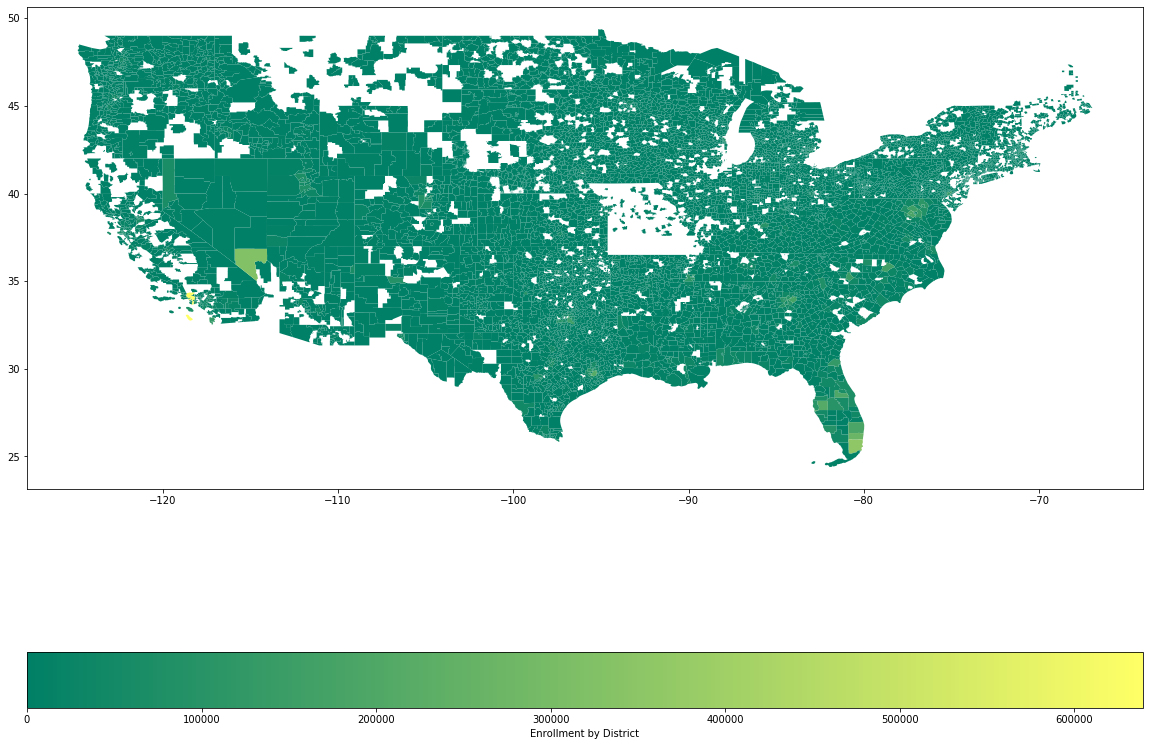

In [733]:
temp = finances_map_2016[~finances_map_2016.STATE.isin(['Alaska', 'Hawaii'])]
fig = temp.plot(column='ENROLL', cmap='summer', figsize = (20,20), legend=True, legend_kwds={'label': "Enrollment by District",
                                                                              'orientation': "horizontal"})


plt.show()

### Some Stuff?

In [506]:
SCHEMA = ['YRDATA',
'NAME',
'ENROLL',
'TOTALREV',
'TFEDREV',
'TSTREV',
'TLOCREV',
'LOCRTAX',
'LOCRPROP',
#'LOCREVPAR',
'PCTTOTAL',
'PCTFTOT',
'PCTSTOT',
'PCTLTOT',
'TOTALEXP',
'TCURSPND',
'TSALWAGE',
'TEMPBENE',
'TCURINST',
'TCURSSVC',
'PPCSTOT',
'PPITOTAL',
'PPSTOTAL']

def n_largest_or_smallest(df, n, operation):
    """Return a sorted df of the n most/least funded districts

        Parameters:
            df (dataframe): the dataframe to be modified
            n (int): the number of districts to keep
            operation (str)['smallest' or 'largest']: whether to return most/least funded 
        Returns:
            new_df (dataframe): A sorted dataframe of the n most/least funded districts in each state
    """
    
    if operation == 'largest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nlargest(n, columns='TOTALREV')) 
    elif operation == 'smallest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nsmallest(n, columns='TOTALREV'))
    else:
        print("operation must be 'largest' or 'smallest'")
        return
    
    return new_df

In [507]:
least_funded = n_largest_or_smallest(df_2016, 3, 'smallest')
most_funded = n_largest_or_smallest(df_2016, 3, 'largest')

least_funded.head()
most_funded.head()

NameError: name 'df_2016' is not defined